## DEMO CL

We recommend starting with the notebook MLP in the directori DEMO/MLP/.

In [1]:
import sys
sys.path.append('../../TINY/')
from mes_imports import *

import TINY 
import UTILS
import SOLVE_EB as EB
import load_data_Loader

from tqdm.notebook import tqdm

## Model

In [2]:
### activation function with MaxPool

class MaxPoolRelu(torch.nn.Module) :
    def __init__(self):
        super(MaxPoolRelu, self).__init__()
        self.kernel_size = 2
    def forward(self, x) :
        return(torch.nn.ReLU()(torch.nn.MaxPool2d(kernel_size=self.kernel_size)(x)))

We define the starting architecture of the model as 4 blocks of convolutional layers followed by 3 linears layer.
We choose to start with 5, resp 10 neurons for the convolutional, resp linear blocks.

In [3]:
layer_name = { 1 : 'CB', 2 : 'CB', 3 : 'CB',4 : 'CB',5 : 'L',6 : 'L',7 : 'L'}

skeleton = {0  : {},
            1 : {'in_channels' : 3, 'out_channels' : 5},
            2 : {'in_channels' : 5, 'out_channels' : 5},
            3 : {'in_channels' : 5, 'out_channels' : 5},
            4 : {'in_channels' : 5, 'out_channels' : 5},
            5 : {'size' : 10},
            6 : {'size' : 10},
            7 : {'size' : 10}}

We use the Relu activation function at each layer and the MaxPool function at layer 2 and 4.

In [18]:
fct = {depth : torch.nn.ReLU() for depth in range(1, 7)}
fct.update({7 : torch.nn.Identity()})
fct.update({2 : MaxPoolRelu()})
fct.update({4 : MaxPoolRelu()})
to_add = [depth for depth in range(1, 7)] # depths where neurons are added
to_add_C = [d for d in to_add if not(layer_name[d][0] == 'L')] # depths where neurons are added and are convolutional layer

depth_seuil = {depth : 10 for depth in range(1, 7)}
architecture_growth = 'Our'
rescale = 'DE'
batch_size = 32

We construct the model :

In [52]:
dico_parameters = {'skeleton' : copy.deepcopy(skeleton),
                    'Loss' : UTILS.Loss_entropy,
                    'fct' : fct,
                    'layer_name' :layer_name,
                    'init_deplacement' : 1e-8,
                    'batch_size' : batch_size,
                    'lr' : 1e-2,
                    'lambda_method' : 0.,
                    'accroissement_decay' : 1e-8,
                    'lu_conv' : 0.001,
                    'max_batch_estimation' : 100,
                    'max_amplitude' : 20.,
                    'ind_lmbda_shape' : 1000,
                    'init_X_shape' : [3, 32, 32],
                    'len_train_dataset' : 50000,
                    'len_test_dataset' : 10000,
                    'T_j_depth' : to_add_C , 
                    'selection_neuron' : UTILS.selection_neuron_seuil,
                    'how_to_define_batchsize' : UTILS.indices_non_constant, 
                    'depth_seuil' : depth_seuil,
                    'architecture_growth' : architecture_growth,
                    'rescale' : rescale
                    }
CL = TINY.TINY(dico_parameters)

## the Dataset
CL.training_data, CL.test_data = load_data_Loader.load_database_CIFAR10()
CL.tr_loader, CL.te_loader =  DataLoader(CL.training_data, batch_size=CL.batch_size, shuffle=True),  DataLoader(CL.test_data, batch_size=CL.batch_size, shuffle=True)
X, Y = CL.get_batch(data = 'tr', device = my_device_0)
X_te, Y_te =  CL.get_batch(data = 'te', device = my_device_0)

Computing matrix T at depth :  1  ...
Computing matrix T at depth :  2  ...
Computing matrix T at depth :  3  ...
Computing matrix T at depth :  4  ...
Files already downloaded and verified
Files already downloaded and verified


The structure of the starting model is :

In [53]:
for k in sorted(list(skeleton.keys()))[1:] :
    if layer_name[k][0] == 'C' :
        print('depth ' + str(k) + ' |  Conv | ' + str(skeleton[k]['in_channels']) + ' -> ' + str(skeleton[k]['out_channels']))
    else :
        print('depth ' + str(k) + ' | Linear | ' + ' -> ' + str(skeleton[k]['size']))

depth 1 |  Conv | 3 -> 5
depth 2 |  Conv | 5 -> 5
depth 3 |  Conv | 5 -> 5
depth 4 |  Conv | 5 -> 5
depth 5 | Linear |  -> 10
depth 6 | Linear |  -> 10
depth 7 | Linear |  -> 10


The starting performance is  :

In [54]:
with torch.no_grad() :
    print('Loss on train :', CL.Loss(Y, CL(X)).item(), ' || Loss on test :', CL.Loss(Y_te, CL(X_te)).item())
    print('Accuracy on train :', UTILS.calculate_accuracy(Y, CL(X)), ' || Accuracy on test :', UTILS.calculate_accuracy(Y_te, CL(X_te)))

Loss on train : -0.7601897120475769  || Loss on test : -0.7744035720825195
Accuracy on train : 0.125  || Accuracy on test : 0.09375


## training the starting model

In [55]:
optimizer = torch.optim.SGD(CL.parameters(), lr = CL.lr)
L_tr, L_te, _, A_tr, A_te, _, T = CL.train_batch(optimizer = optimizer, nbr_epoch = 0.01)

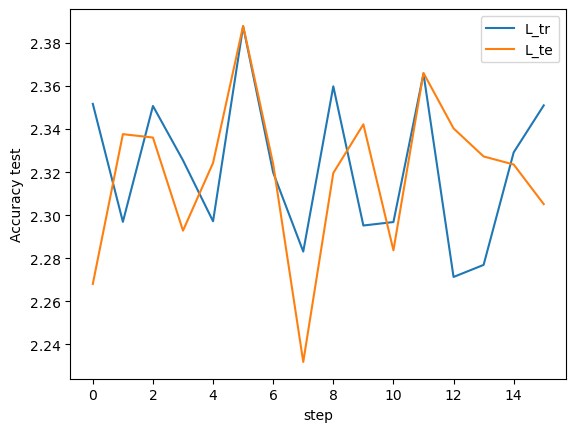

In [56]:
plt.plot(L_tr, label = 'L_tr')
plt.plot(L_te, label = 'L_te')
plt.xlabel('step')
plt.ylabel('Accuracy test')
plt.legend()
plt.show()

## Architecture growth and training

In [59]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])

nbr_pass = 2
nbr_epochs_betw_adding = 0.5

path = 'resultats/'

In [60]:
def update_quantity_of_interest() :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    dico_tracker = {'vps' + str(i) : [ CL.valeurs_propres[i].item()] for i in range(len(CL.valeurs_propres))}
    
    dico_tracker.update({'depth_add' : best_depth, 'nbr_added_neuron': CL.nbr_added_neuron})
    dico_tracker.update({'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [CL.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [CL.lu_conv]})
    
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index = True)
    
    L_tr = np.concatenate([L_tr, l_tr])
    L_te = np.concatenate([L_te, l_te])
    A_tr = np.concatenate([A_tr, a_tr])
    A_te = np.concatenate([A_te, a_te])
    T = np.concatenate([T, t +  T[-1]])

    
    
def stabilize_training() :
    CL.batch_size = math.ceil(np.sqrt(CL.count_parameters() / nbr_parameters_avant) *  CL.batch_size)
    #CL.batch_size = math.ceil(CL.count_parameters() / nbr_parameters_avant *  CL.batch_size)

In [61]:
count = 1

In [62]:
for j in tqdm(range(nbr_pass)) :
    nbr_parameters_avant = CL.count_parameters()
    gc.collect()
    torch.cuda.empty_cache()
    
    depth_ajout = to_add
    depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(CL, depths = depth_ajout)

    best_depth = depth_in_decreasing_criterion[0]
    dico_EB_bd = dico_EB[best_depth]
    alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
    lambda_method = dico_EB_bd['beta_min']

    CL.alpha, CL.omega, CL.bias_alpha, CL.valeurs_propres = None, None, None, []
    CL.TAB_Add = None

    if lambda_method > 0 :
        CL.dico_w, CL.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
        EB.add_neurons(CL, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
        CL.lambda_method = torch.tensor(0., device = my_device_0)

       
    stabilize_training()
    CL.tr_loader = DataLoader(CL.training_data, batch_size=CL.batch_size, shuffle=True)
    CL.te_loader = DataLoader(CL.test_data, batch_size=CL.batch_size, shuffle=True)
    optimizer = torch.optim.SGD(CL.parameters(), lr = CL.lr)

    l_tr, l_te, l_va, a_tr, a_te, a_va, t = CL.train_batch(nbr_epochs_betw_adding, optimizer = optimizer)

    update_quantity_of_interest()

    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * CL.batch_size})
    df_tracker.to_csv(path + '/df_tracker.csv', index=False)
    df_performance.to_csv(path + '/df_performance.csv', index=False)
    CL.T = T[-1]
    CL.len_L_tr = len(L_tr)
    UTILS.save_model_to_file(CL, path = path + '/' , name='model_' + str(count))
    count += 1

  0%|          | 0/2 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 782.40869140625
norm_x_over_norm_DE_depthp1 :  66.57452392578125
L_plus < L_moins: 2.3171656131744385 < 2.3171658515930176
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0019741058349609375, -0.002562999725341797, -0.002274036407470703]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.0011036706855520606 ampli_fct : 0.0009765625 L[0] : 2.3222503662109375


*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 170.44

Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [2.384185791015625e-07, 4.76837158203125e-07, 9.5367431640625e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.0384597778320312


*** started  Add at  3 ***
Batch size for estimation : 400
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 1.005216121673584
norm_x_over_norm_DE_depthp1 :  0.5634731650352478
amplitude factor for the new neurons : 0.015625
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  3 ***




## plotting

In [63]:
df_tracker = pd.read_csv(path + 'df_tracker.csv')
df_performance = pd.read_csv(path + 'df_performance.csv')

In [67]:
coef = 100 # smoothing coefficient 
kernel = torch.zeros(1, 1, coef)
C = 10
for i, t1 in enumerate(torch.linspace(-C, C, coef)[:int(coef/2) + 1]) :
    t2 = t1 + 2*C/(coef/2)
    #if t1 <= 0 :
    h = torch.distributions.normal.Normal(0, 1).cdf(t2) - torch.distributions.normal.Normal(0, 1).cdf(t1)
    kernel[0, 0, i] = h
kernel /= kernel.sum()

In [68]:
A_tr_padd = torch.concatenate([torch.ones(int(coef/2)) * df_performance['A_tr'][:5].mean(), 
                               torch.from_numpy(df_performance['A_tr'].values.astype(np.float32)),
                               torch.ones(int(coef/2)) * df_performance['A_tr'][-5:].mean()])
A_te_padd = torch.concatenate([torch.ones(int(coef/2)) * df_performance['A_te'][:5].mean(), 
                               torch.from_numpy(df_performance['A_te'].values.astype(np.float32)),
                               torch.ones(int(coef/2)) * df_performance['A_te'][-5:].mean()])
smooth_A_tr = torch.nn.functional.conv1d(A_tr_padd[None, None, :], kernel, padding = 0)
smooth_A_te = torch.nn.functional.conv1d(A_te_padd[None, None, :], kernel, padding = 0)

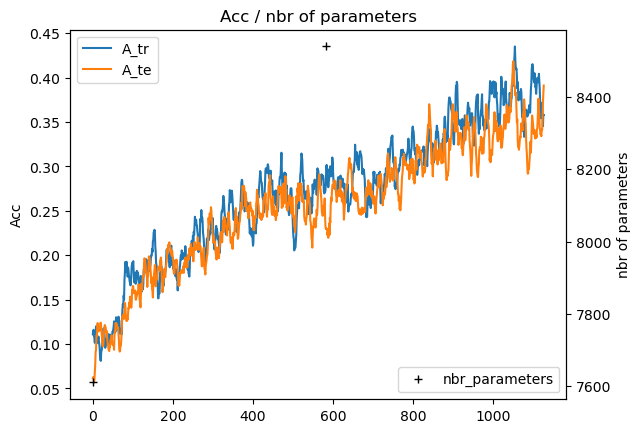

In [69]:
fig, ax = plt.subplots(1, 1)
ax.plot(smooth_A_tr[0, 0], label = 'A_tr')
ax.plot(smooth_A_te[0, 0], label = 'A_te')

ax.legend()
ax_nbrp = ax.twinx()
ax_nbrp.plot(df_tracker['len_L_tr'], df_tracker['nbr_parameters_apres'], '+', label = 'nbr_parameters', color = 'black')
ax_nbrp.legend(loc = 'lower right')
ax.set_title('Acc / nbr of parameters')
ax.set_ylabel('Acc')
ax_nbrp.set_ylabel('nbr of parameters')
plt.show()

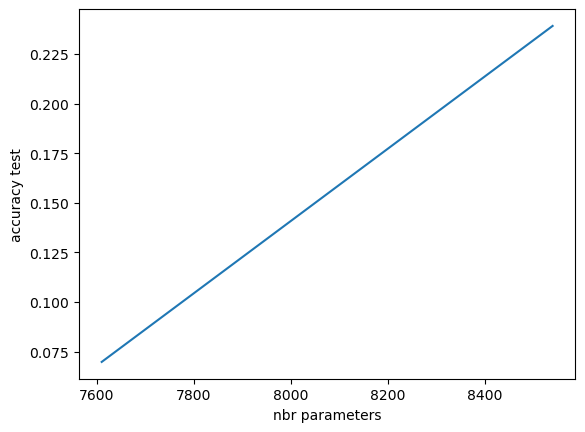

In [70]:
coef = 1
plt.plot(df_tracker['nbr_parameters_apres'], UTILS.lisser_courbe(df_performance['A_te'].values, coef = coef)[(df_tracker['len_L_tr'].values /coef).astype(int)])
plt.xlabel('nbr parameters')
plt.ylabel('accuracy test')
plt.show()